ReadMe:\
    This notebook is an example using the burst analysis functions from AnalysisFunctions.ipynb on spike time data.
    The AnalysisFunctions.ipynb is imported as a module. Neuron spike times are previously saved to a dataset. 
    Names and style are consistent with braingeneerspy.analysis. If use API, delete *'%run AnalysisFunctions.ipynb'*.

# Import APIs

In [259]:
import numpy as np

In [260]:
%run AnalysisFunctions.ipynb # If call braingeneerspy.analysis, delete this line

# Run Analysis

In [261]:
# load spike time numpy file
spike_times_hq = np.load('mid/spike_times_hq.npy', allow_pickle=True)

In [262]:
# assign data to each day in vitro
# each day has its SpikeData class
for i in range(len(spike_times_hq)):
    exec(f'DIV_{15+2*i} = SpikeData(spike_times_hq[i])')


In [263]:
isi_23 = DIV_23.interspike_intervals()
print(len(isi_23))
print(isi_23[2], len(isi_23[2]))

22
[7.26184 3.91536 4.79328 ... 0.76584 2.30864 1.45568] 7624


In [264]:
logISIH_23, logbins_23 = DIV_23.log_histogram()
print(len(logISIH_23), len(logbins_23))
print(len(logISIH_23[0]))

22 22
300


In [265]:
ISIth_cma_23 = DIV_23.isi_threshold_cma(logISIH_23, logbins_23)
print(ISIth_cma_23)

[48.3173829818107, 0.010520231351133901, 0.025877188523767844, 0.02105514148892239, 0.19043556629690098, 0.06814405676974479, 0.01706623557292908, 0.020807659635051573, 0.00977692516590035, 0.021607414739216083, 0.011621932379207696, 0.013380495616464509, 0.010180402431798923, 0.01826799764204436, 0.016253362364937088, 0.012202048189003754, 0.01454456677889443, 0.01564943930850371, 0.12161477119252782, 0.03006626161715912, 0.013534687036008738, 0.15507088005470177]


# plot (smoothed) histogram 

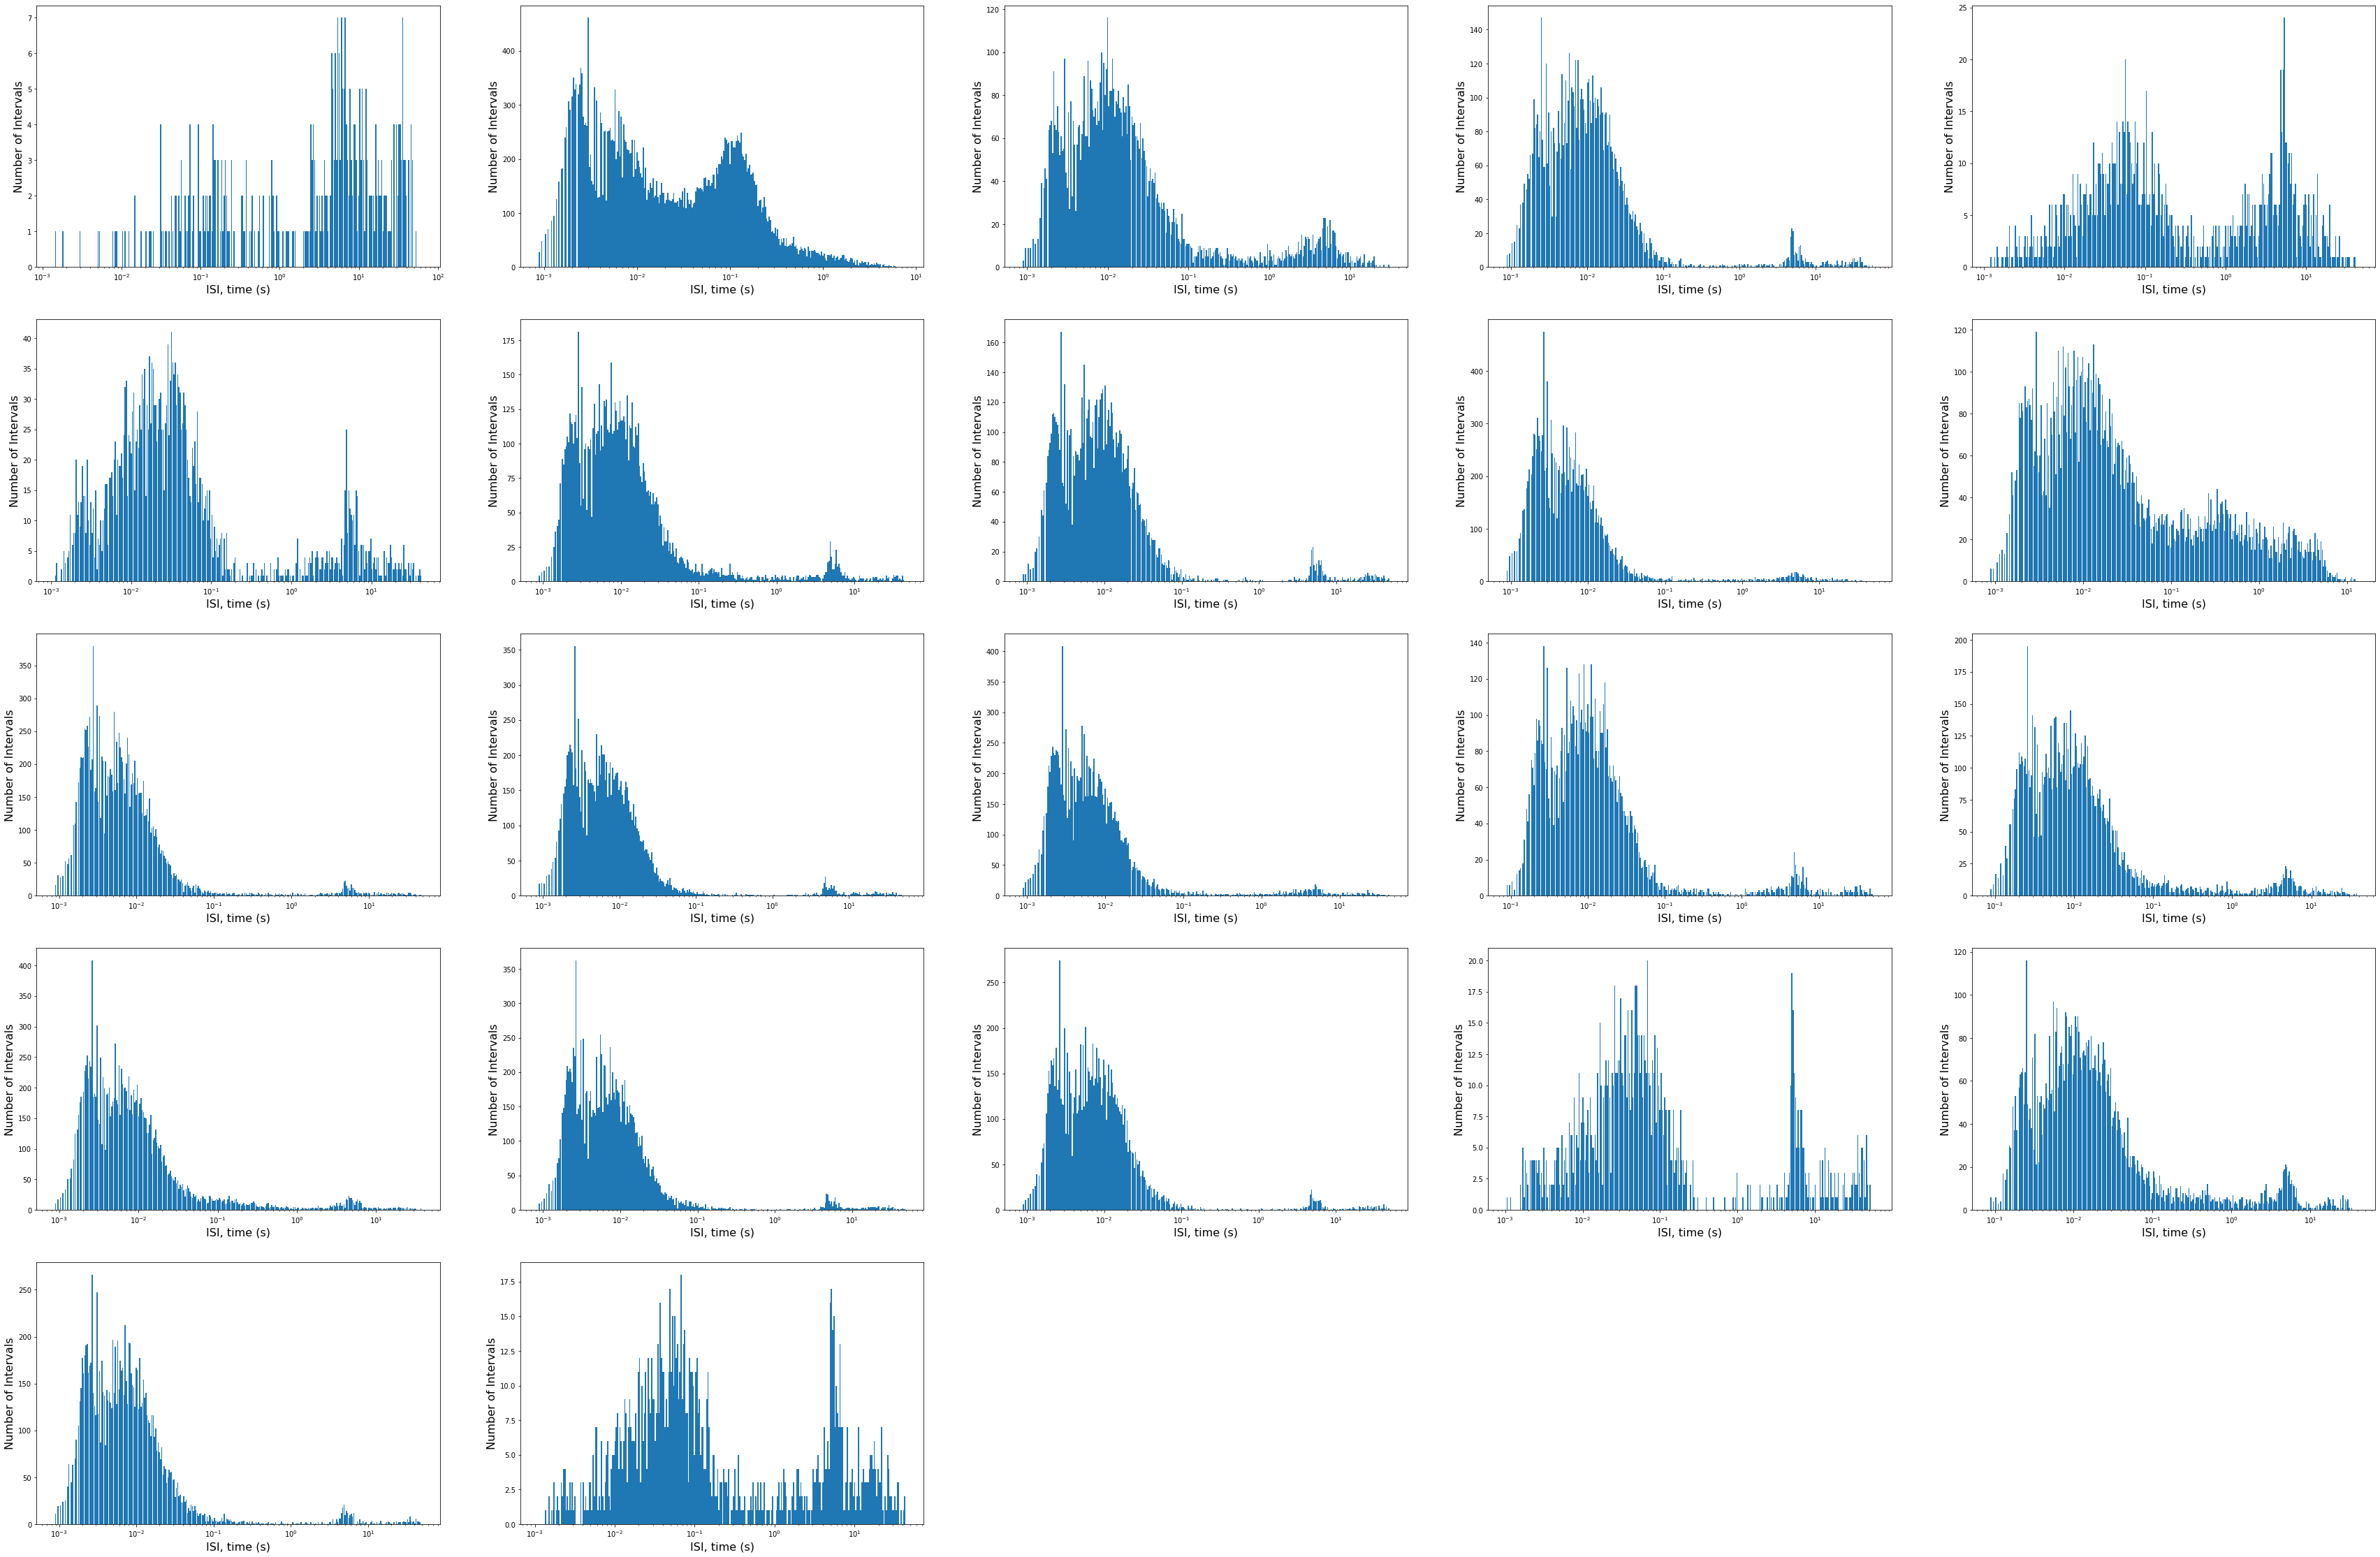

In [267]:
logISI_histogram(isi_23, logbins_23)

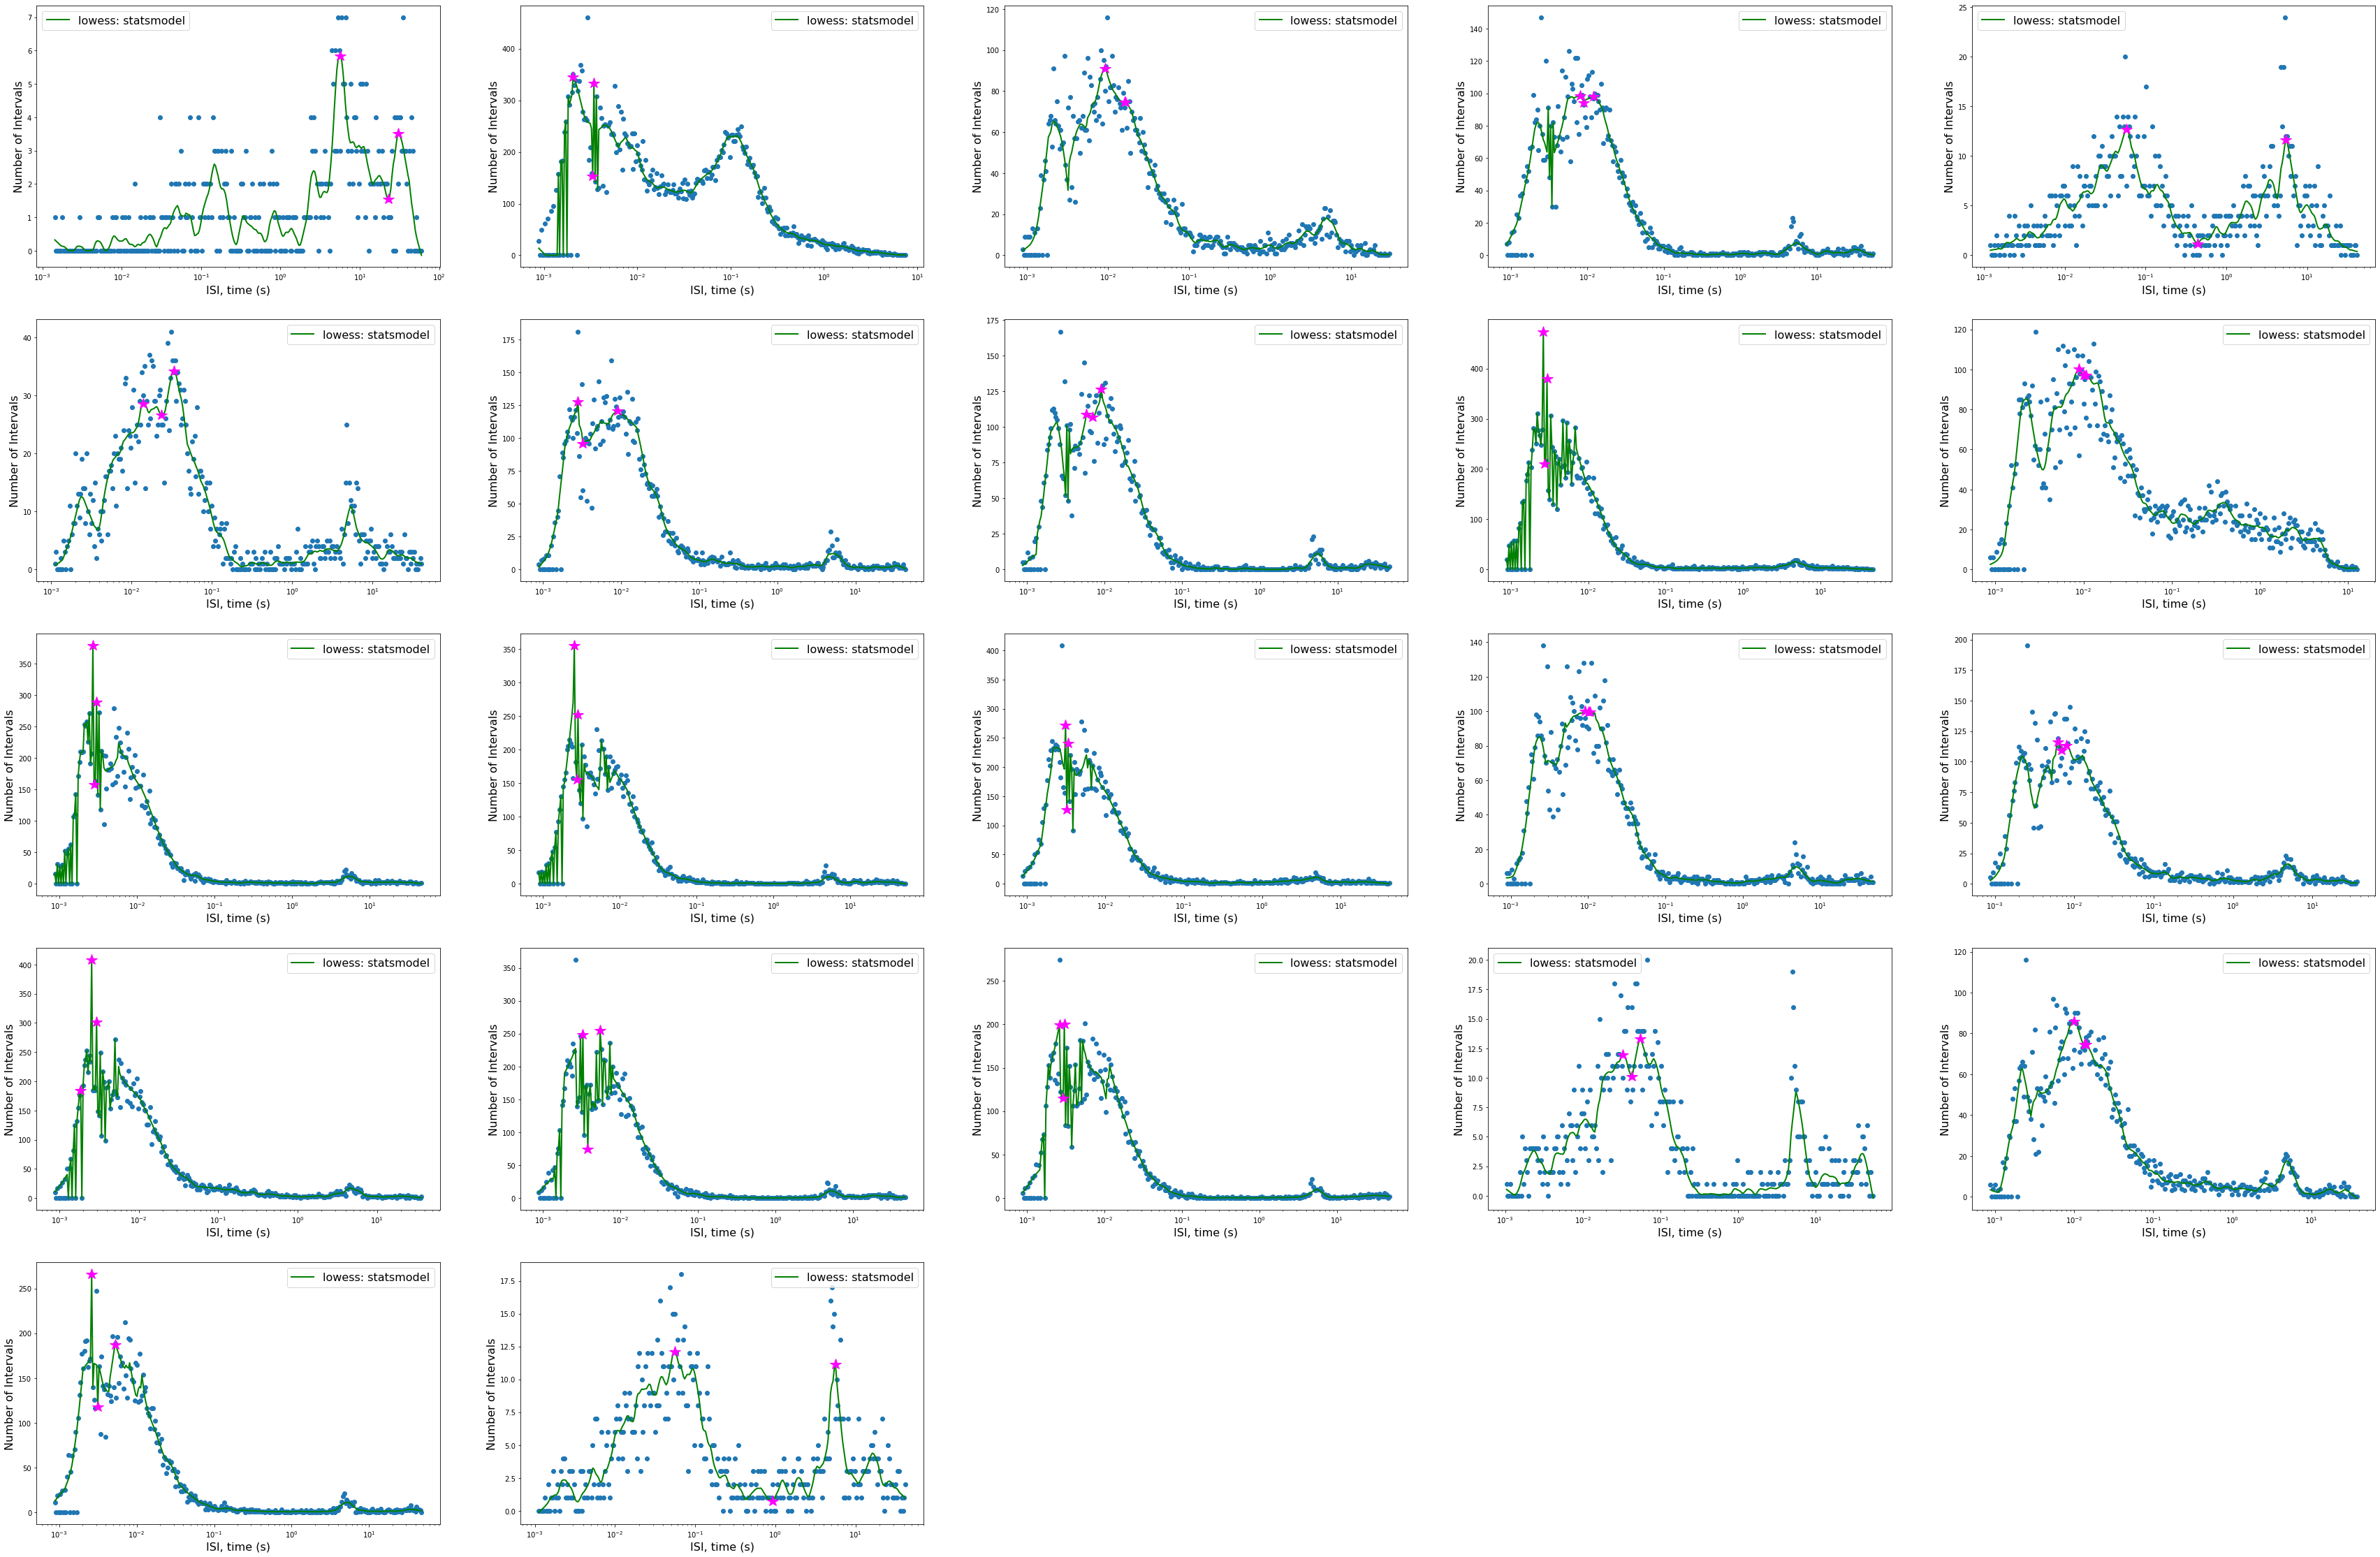

In [272]:
smoothed_LogISIH(logISIH_23, logbins_23)

# Find threshold and detect burst for each neuron

## Determine threshold

In [273]:
# find burst threshold by comparing cma, local minima (with void parameter) and manual threshold, choose the minumum of three
# Note: this don't need to be a function. It's an example using cma and pm to find the desired threshold.
manual_thr = 0.1 
burst_thr_23 = []
for i in range(len(logISIH_23)):
    bins_n = logbins_23[i]
    logisi_sm = lowess_smooth(logISIH_23[i], bins_n)
    pk_1, pk_2, vly = peaks_and_valleys(logisi_sm)
    vp = void_parameter(pk_1[0], pk_2[0], vly[0])
    isi_cma = ISIth_cma_23[i]

    if vp > 0.7 and bins_n[vly[1]+1] < isi_cma:
        burst_up_thr = bins_n[vly[1]+1]
    else: 
        burst_up_thr = isi_cma
    if burst_up_thr > manual_thr:
        burst_up_thr = manual_thr
    burst_thr_23.append(burst_up_thr)

print(len(burst_thr_23), burst_thr_23)

22 [0.1, 0.010520231351133901, 0.025877188523767844, 0.02105514148892239, 0.1, 0.06814405676974479, 0.01706623557292908, 0.020807659635051573, 0.00977692516590035, 0.021607414739216083, 0.011621932379207696, 0.013380495616464509, 0.010180402431798923, 0.01826799764204436, 0.016253362364937088, 0.012202048189003754, 0.003918720306227529, 0.01564943930850371, 0.1, 0.03006626161715912, 0.013534687036008738, 0.1]


## Burst detection

In [275]:
# calculate metrics
def burst_measures(spike_times, spike_num_list):     # is 'measures' the right word?
    print("Total number of bursts in this recording: ", len(spike_num_list))
    
    num_spikes = []
    burst_duration = []
    for unit in spike_num_list:
        num_spikes.append(unit[1])
        start_point = spike_times[unit[0]]
        end_point = spike_times[unit[0] + unit[1] - 1]
        burst_duration.append(end_point - start_point)
        
    burst_intervals = []
    for j in range(len(spike_num_list)-1):
        st = spike_num_list[j][0] + spike_num_list[j][1] -1
        en = spike_num_list[j+1][0]
        burst_intervals.append(spike_times[en] - spike_times[st])
    
    return num_spikes, burst_duration, burst_intervals

In [276]:
def print_burst_measures(num_spikes, burst_duration, burst_intervals):
    # average number of spikes in a burst   
    num_spikes = np.array(num_spikes)
    mean_num_spikes = np.mean(num_spikes)
    std_num_spikes = np.std(num_spikes)
    print("Average number of spikes in a burst: ", mean_num_spikes)
    print(" with standard deviation: ", std_num_spikes)
    
    # average burst duration
    burst_duration = np.array(burst_duration)
    mean_burst_duration = np.mean(burst_duration)
    std_burst_duration = np.std(burst_duration)
    print("Average burst duration: ", mean_burst_duration, "second")
    print(" with standard deviation: ", std_burst_duration)
    
    # average burst interval
    burst_intervals = np.array(burst_intervals)
    mean_burst_interval = np.mean(burst_intervals)
    std_burst_interval = np.std(burst_intervals)
    print("Average interval between adjacent bursts: ", mean_burst_interval, "second")
    print(" with standard deviation: ", std_burst_interval)

# Burst detection for day 23

## Run detection

In [277]:
print(len(DIV_23.train))

22


In [278]:
burst_dict_23 = []
burst_set_23 = []
burst_st_23 = []
for i in range(len(DIV_23.train)):
    spike_times = DIV_23.train[i]
    burst_dict, burst_set = burst_detection(spike_times, burst_thr_23[i])
#     print(burst_dict[0:10])
#     print(burst_set[0:10])
    burst_st = []
    for data in burst_dict:
        burst_st.append(spike_times[data[0]])
    burst_dict_23.append(burst_dict)
    burst_set_23.append(burst_set)
    burst_st_23.append(burst_st)
print(len(burst_dict_23))
print(len(burst_set_23))
print(len(burst_st_23))

22
22
22


## plot raster with labeled bursts

ISI threshold for neuron 0 : 0.1
Total number of bursts in this recording:  14
Average number of spikes in a burst:  3.2857142857142856
 with standard deviation:  0.5890150893739516
Average burst duration:  0.0921942857143035 second
 with standard deviation:  0.04844702994206322
Average interval between adjacent bursts:  212.09132923076925 second
 with standard deviation:  213.6704938412753


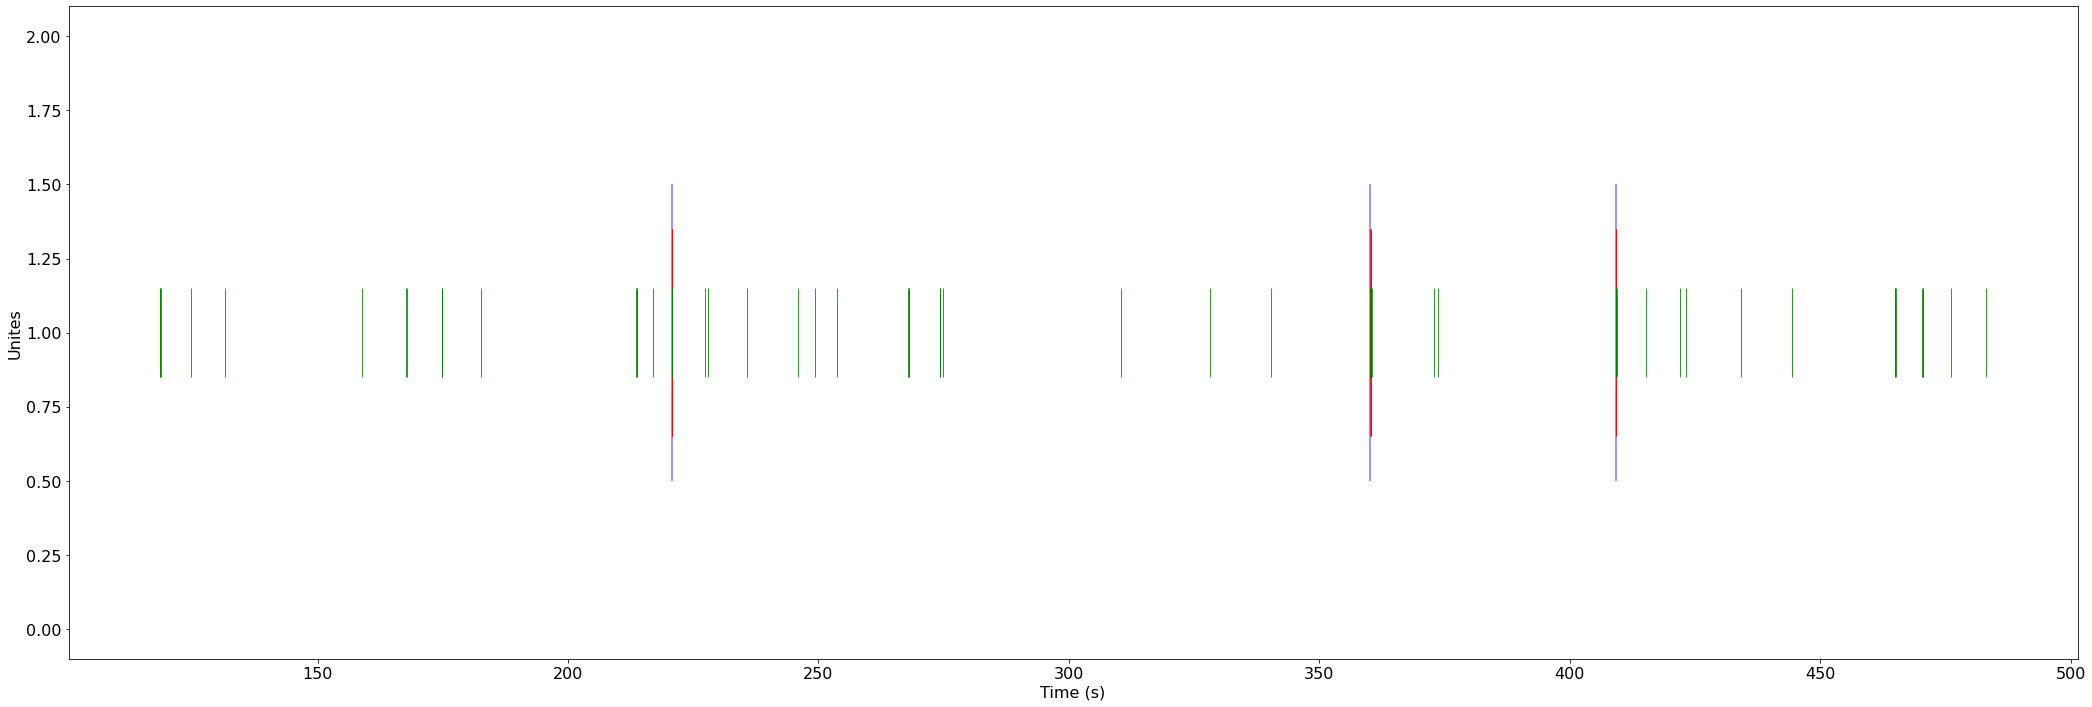

In [280]:
i = 0
print("ISI threshold for neuron %s" %i, ":", burst_thr_23[i])
num_spikes, burst_duration, burst_intervals = burst_measures(DIV_23.train[i], burst_dict_23[i])
print_burst_measures(num_spikes, burst_duration, burst_intervals)
labeled_raster(DIV_23.train[i], burst_set_23[i], burst_st_23[i], True, 100, 500)

ISI threshold for neuron 1 : 0.010520231351133901
Total number of bursts in this recording:  1675
Average number of spikes in a burst:  9.202388059701493
 with standard deviation:  9.70817136808453
Average burst duration:  0.03555615522387616 second
 with standard deviation:  0.03936533029705647
Average interval between adjacent bursts:  2.0998285304659543 second
 with standard deviation:  6.604781329235211


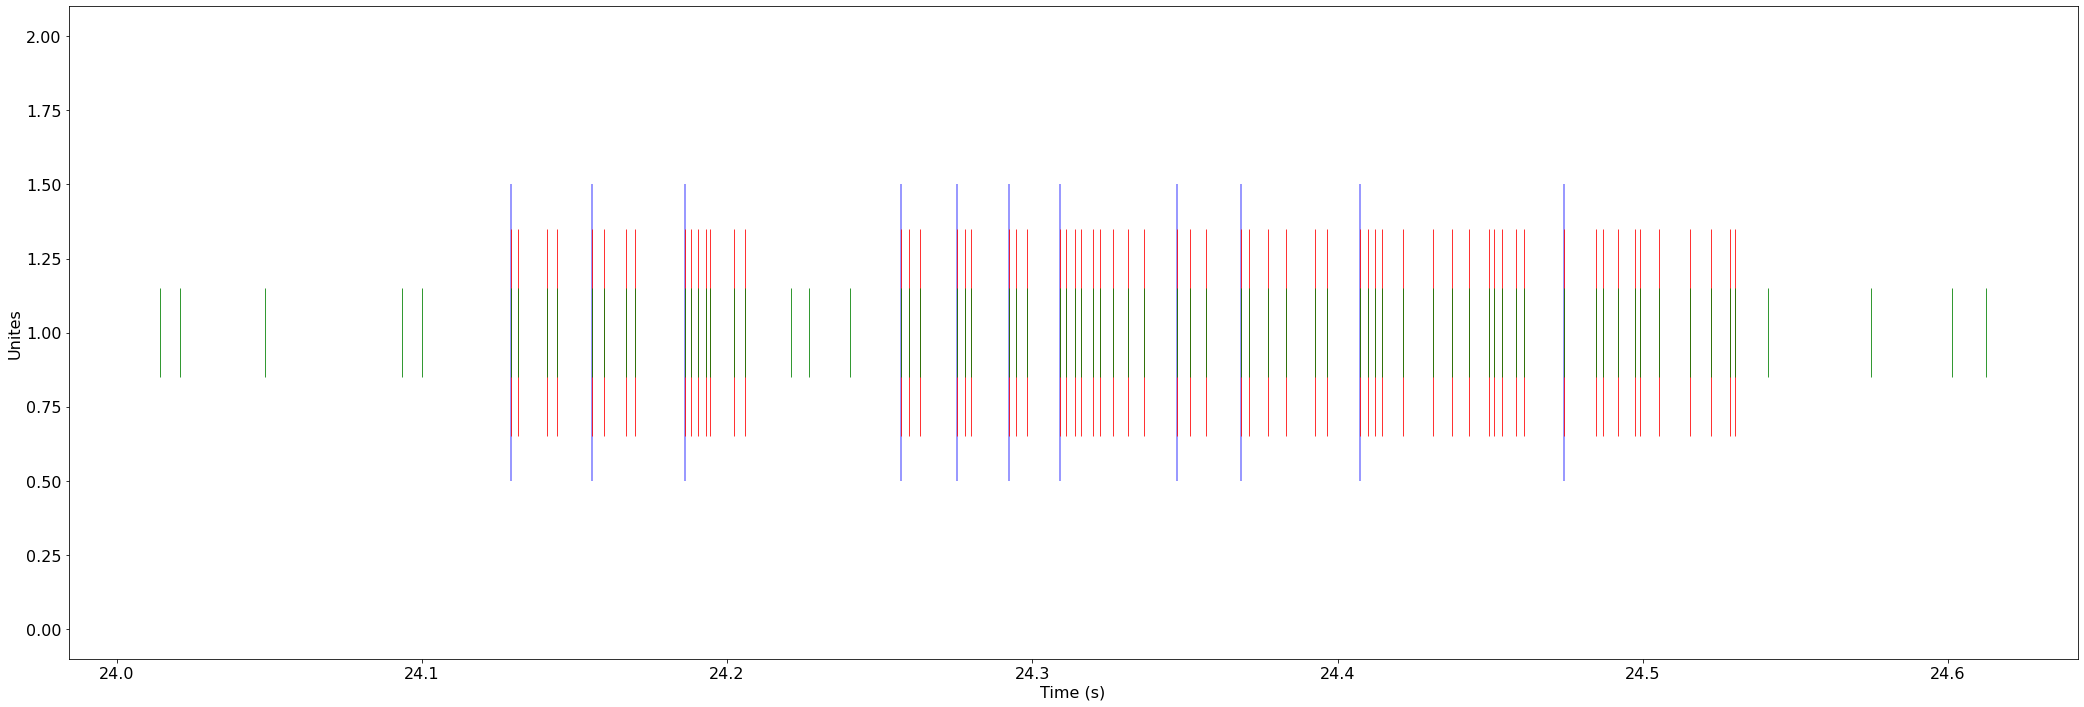

In [281]:
i = 1
print("ISI threshold for neuron %s" %i, ":", burst_thr_23[i])
num_spikes, burst_duration, burst_intervals = burst_measures(DIV_23.train[i], burst_dict_23[i])
print_burst_measures(num_spikes, burst_duration, burst_intervals)
labeled_raster(DIV_23.train[i], burst_set_23[i], burst_st_23[i], True, 24, 24.75)

ISI threshold for neuron 10 : 0.011621932379207696


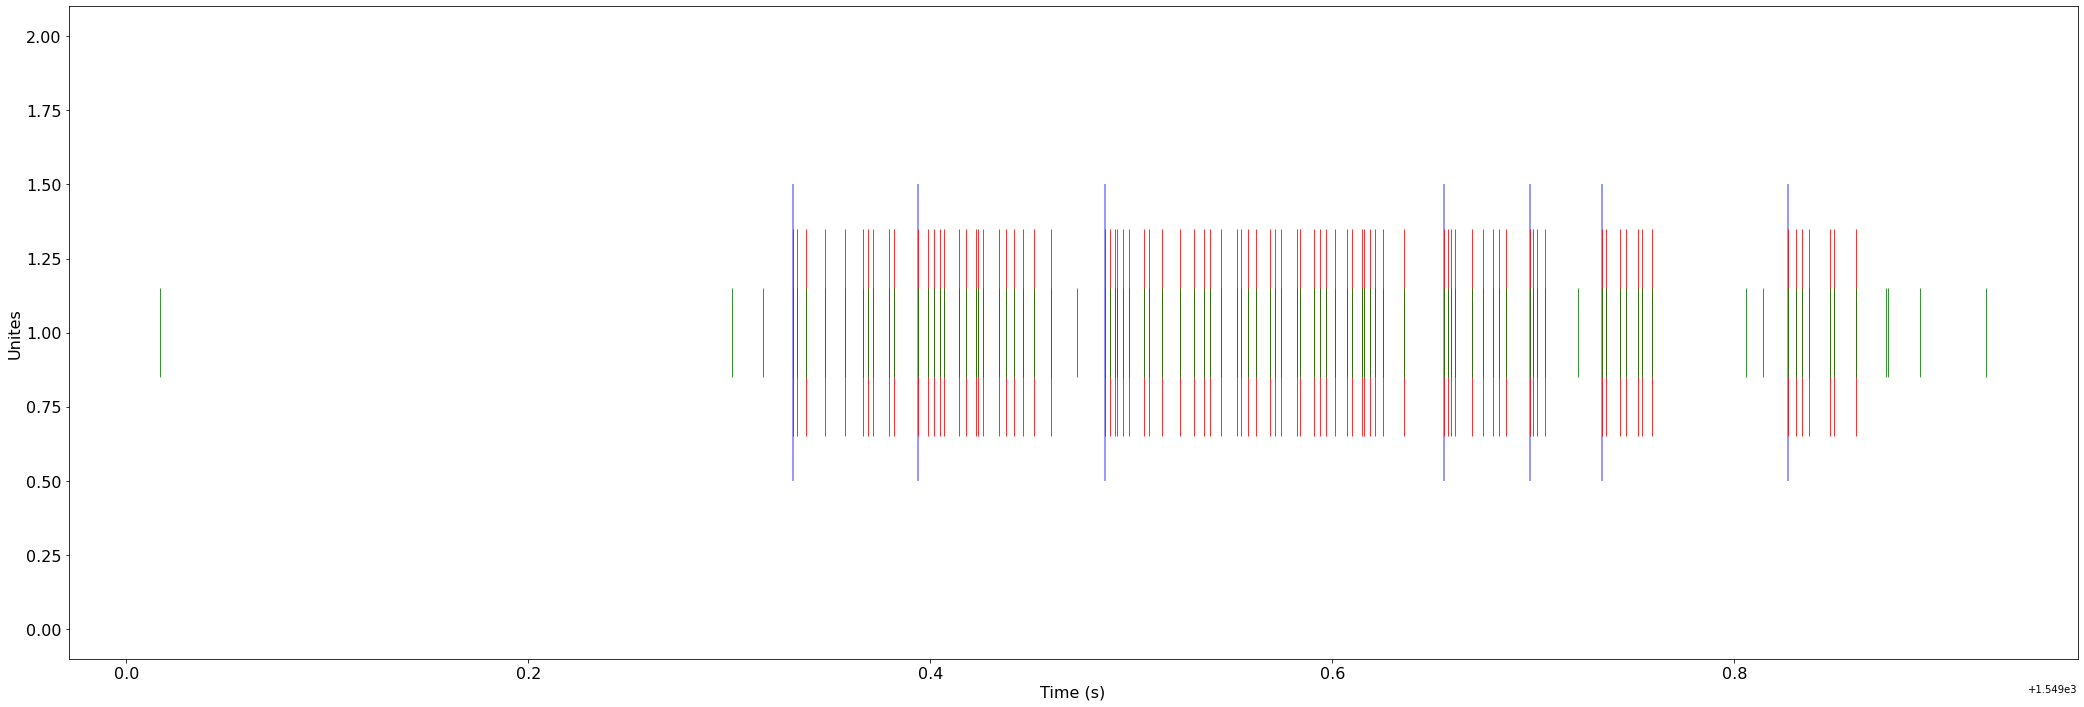

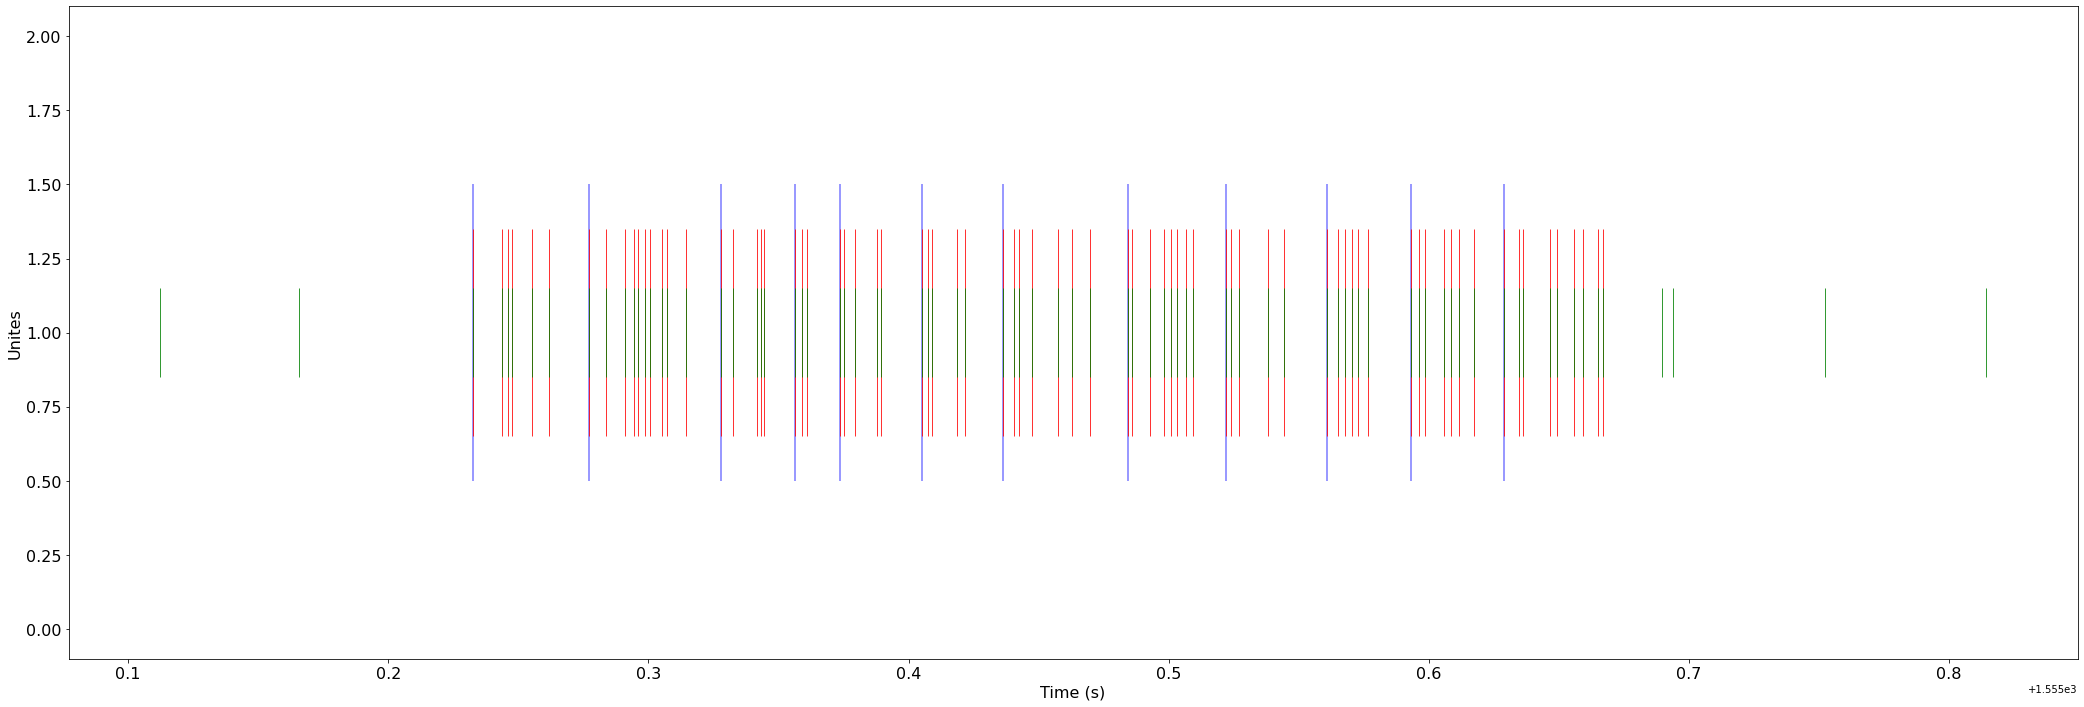

In [282]:
i = 10
print("ISI threshold for neuron %s" %i, ":", burst_thr_23[i])
labeled_raster(DIV_23.train[i], burst_set_23[i], burst_st_23[i], True, 1549, 1550)
labeled_raster(DIV_23.train[i], burst_set_23[i], burst_st_23[i], True, 1555, 1556)